In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
data = files.upload()

Saving data.csv to data.csv


In [5]:
import torch
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    Trainer,
    TrainingArguments
)
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

os.environ["WANDB_DISABLED"] = "true"

df = pd.read_csv("data.csv")


text_col = next(col for col in ['text', 'headline', 'title', 'content'] if col in df.columns)
label_col = next(col for col in ['label', 'is_clickbait', 'clickbait'] if col in df.columns)


train_texts, test_texts, train_labels, test_labels = train_test_split(
    df[text_col],
    df[label_col],
    test_size=0.3,
    random_state=42,
    stratify=df[label_col]
)

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')


train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding=True, max_length=128)
test_encodings = tokenizer(test_texts.tolist(), truncation=True, padding=True, max_length=128)


class ClickbaitDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels.iloc[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = ClickbaitDataset(train_encodings, train_labels)
test_dataset = ClickbaitDataset(test_encodings, test_labels)


training_args = TrainingArguments(
    output_dir='./results',
    run_name='clickbait-bert-run-1',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_steps=100,
    load_best_model_at_end=True
)


model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,0.061400,0.046948
2,0.009200,0.055197
3,0.002300,0.063506


TrainOutput(global_step=8298, training_loss=0.03841408887504544, metrics={'train_runtime': 20944.3183, 'train_samples_per_second': 3.169, 'train_steps_per_second': 0.396, 'total_flos': 652452131106072.0, 'train_loss': 0.03841408887504544, 'epoch': 3.0})

In [16]:
# Get predictions on test set
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)


# Generate classification report
from sklearn.metrics import classification_report
print(classification_report(test_labels, y_pred, target_names=['News', 'Clickbait']))

              precision    recall  f1-score   support

        News       0.99      0.99      0.99      4766
   Clickbait       0.99      0.99      0.99      4715

    accuracy                           0.99      9481
   macro avg       0.99      0.99      0.99      9481
weighted avg       0.99      0.99      0.99      9481



              precision    recall  f1-score   support

        News       0.99      0.99      0.99      4766
   Clickbait       0.99      0.99      0.99      4715

    accuracy                           0.99      9481
   macro avg       0.99      0.99      0.99      9481
weighted avg       0.99      0.99      0.99      9481

Confusion Matrix:
 [[4704   62]
 [  51 4664]]


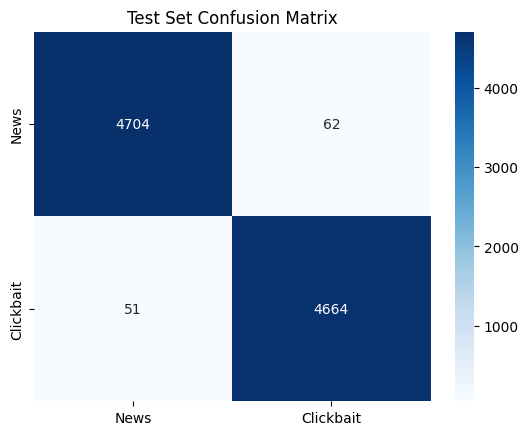

In [13]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_labels, y_pred, target_names=['News', 'Clickbait']))
cm = confusion_matrix(test_labels, y_pred)
print("Confusion Matrix:\n", cm)
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['News', 'Clickbait'],
            yticklabels=['News', 'Clickbait'])
plt.title('Test Set Confusion Matrix')
plt.savefig('test_confusion_matrix.png')

In [7]:
model.save_pretrained("./clickbait_bert_model")
tokenizer.save_pretrained("./clickbait_bert_model")

('./clickbait_bert_model/tokenizer_config.json',
 './clickbait_bert_model/special_tokens_map.json',
 './clickbait_bert_model/vocab.txt',
 './clickbait_bert_model/added_tokens.json',
 './clickbait_bert_model/tokenizer.json')

In [9]:
import gradio as gr

def predict(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True)
    outputs = model(**inputs)
    prob = torch.softmax(outputs.logits, dim=1)[0][1].item()
    return {"Clickbait": prob, "News": 1-prob}

gr.Interface(
    fn=predict,
    inputs="text",
    outputs="label",
    examples=["You won't believe this trick!", "Official statement released"]
).launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c6eae361b392d5779a.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
